## Detecting Hate Speech
Mick Leungpathomaram


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import nltk
import torch
import torchvision
import torchtext
import re
from re import findall, sub
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder

nltk.download("stopwords")
nltk.download('punkt')
from nltk.corpus import stopwords

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.metrics import f1_score
from sklearn.svm import SVR
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pandas import get_dummies

from torch import nn
from torch.nn import functional
from torch.utils.data import DataLoader, TensorDataset

from torchtext.data import get_tokenizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
!pip3 install datasets
import datasets

In [3]:


# loads the dataset from https://huggingface.co/datasets/ucberkeley-dlab/measuring-hate-speech.
# the "train" split is the only split in the dataset, so we need to separate this.

dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech')

df = dataset['train'].to_pandas()
df.describe()



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/135556 [00:00<?, ? examples/s]

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,hatespeech,hate_speech_score,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,annotator_age
count,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.00000,135556.000000,135556.000000,135556.000000,135556.000000,...,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135451.000000
mean,23530.416138,5567.097812,1.281352,2.954307,2.828875,2.56331,2.278638,2.698575,1.846211,1.052045,...,0.744733,-0.567428,1.034322,1.001052,-0.018817,0.300588,1.007158,1.011841,0.014589,37.910772
std,12387.194125,3230.508937,1.023542,1.231552,1.309548,1.38983,1.370876,0.898500,1.402372,1.345706,...,0.932260,2.380003,0.496867,0.791943,0.487261,0.236380,0.269876,0.675863,0.613006,11.641276
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-8.340000,0.100000,0.070000,-1.820000,0.020000,0.390000,0.280000,-1.578693,18.000000
25%,18148.000000,2719.000000,0.000000,2.000000,2.000000,2.00000,1.000000,2.000000,1.000000,0.000000,...,0.000000,-2.330000,0.710000,0.560000,-0.380000,0.030000,0.810000,0.670000,-0.341008,29.000000
50%,20052.000000,5602.500000,1.000000,3.000000,3.000000,3.00000,3.000000,3.000000,2.000000,0.000000,...,0.000000,-0.340000,0.960000,0.830000,-0.020000,0.340000,0.970000,0.850000,0.110405,35.000000
75%,32038.250000,8363.000000,2.000000,4.000000,4.000000,4.00000,3.000000,3.000000,3.000000,2.000000,...,2.000000,1.410000,1.300000,1.220000,0.350000,0.420000,1.170000,1.130000,0.449555,45.000000
max,50070.000000,11142.000000,3.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,...,2.000000,6.300000,5.900000,9.000000,1.360000,1.900000,2.010000,9.000000,0.987511,81.000000


# Pre-Processing

In [4]:
stop_words = set(stopwords.words('english'))


def remove_mentions(text):
    expression = r"@([^ ]+)"
    text = re.sub(expression, "@", text)
    return text

def remove_tags(text):
    expression = r"(#[^ ]*)"
    text = re.sub(expression, "", text)
    return text


def remove_non_printable(text):
    expression = r'[^\x20-\x7E]'
    text = re.sub(expression, "~", text)

    return text

def remove_punctuation(text):
    expression = r'[.,\']'
    text = re.sub(expression, "", text)

    return text


In [45]:
#Splitting
train, test = train_test_split(df, test_size=.5)

# Currently only using hate_speech_score. Might predict more in later iterations.
train_y = train['hate_speech_score']
train_X = train['text']

test_y = test['hate_speech_score']
test_X = test['text']


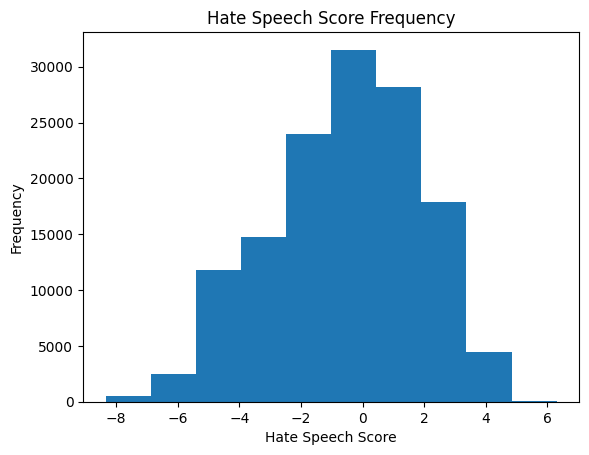

In [76]:
plt.hist(df['hate_speech_score'])
plt.title("Hate Speech Score Frequency")
plt.xlabel("Hate Speech Score")
plt.ylabel("Frequency")
plt.show()

In [77]:
print(np.mean(df['hate_speech_score']))
print(np.median(df['hate_speech_score']))
print(np.std(df['hate_speech_score']))

-0.5674283690873143
-0.34
2.379994472074863


In [46]:


train_X = train_X.str.lower()
train_X = train_X.apply(lambda text: ' '.join([word for word in text.split() if word not in (stop_words)]))

train_X = train_X.apply(remove_tags)
train_X = train_X.apply(remove_mentions)

train_X = train_X.apply(remove_non_printable)
train_X = train_X.apply(remove_punctuation)


test_X = test_X.str.lower()
test_X = test_X.apply(lambda text: ' '.join([word for word in text.split() if word not in (stop_words)]))
test_X = test_X.apply(remove_tags)
test_X = test_X.apply(remove_mentions)

test_X = test_X.apply(remove_non_printable)
test_X = test_X.apply(remove_punctuation)


# Feature Engineering Functions

In [47]:

## Function to measure percentage of numbers
def num_prop(text):
  return sum(map(str.isdigit, text))/len(text)

#proportion of non-alphanumeric characters.
def non_alphnum_prop(text):
  text = text.replace(" ", "")
  num_chars = len(text)
  if num_chars == 0:
    return 0

  count = sum(1 for char in text if not char.isalnum())
  return count / num_chars
## Function to count exclamation marks
def num_exclamation_points(text):
  return text.count('!')


def num_tags(text):
  return text.count('@')

def has_url(text):
  return "url" in text.lower()

def length(text):
  return len(text.split())

#percentage of capital letters
def capital_percent(text):
  return len(findall(r'[A-Z]', text))/len(text)


from torchtext.data.utils import get_tokenizer
from collections import Counter

tokenizer = get_tokenizer("basic_english")

# generate counter creates a dictionary with each word and
# the number of times it appears in the data
def generate_counter(tokenizer, data):
  counter = Counter()

  for text in data:
      counter.update(tokenizer(text))
  return counter


In [48]:
hate = train_X.loc[train_y >=0]
support = train_X.loc[train_y < 0]

n = train_y.between(-0.5,1, 'both')
neutral = train_X.loc[n==1]

#create counters
hate_counter=generate_counter(tokenizer, hate)
support_counter = generate_counter(tokenizer, support)
neutral_counter = generate_counter(tokenizer, neutral)



In [49]:
hate_counter.most_common(50)

[('!', 19030),
 ('fucking', 6291),
 ('fuck', 5833),
 ('@', 5316),
 ('?', 4919),
 ('hate', 4067),
 ('people', 3806),
 ('niggers', 3634),
 ('bitch', 3581),
 ('like', 3513),
 ('go', 3506),
 ('get', 3468),
 ('stupid', 2665),
 ('kill', 2383),
 ('url', 2364),
 ('back', 2255),
 ('nigger', 2217),
 ('ass', 2118),
 ('women', 2075),
 ('country', 2009),
 ('white', 1945),
 ('black', 1890),
 ('die', 1820),
 ('need', 1749),
 ('even', 1748),
 ('know', 1683),
 ('every', 1626),
 ('right', 1577),
 ('shit', 1560),
 ('human', 1551),
 ('u', 1551),
 ('want', 1492),
 ('muslims', 1472),
 ('one', 1472),
 ('us', 1417),
 ('muslim', 1415),
 ('here', 1346),
 ('world', 1341),
 ('scum', 1328),
 ('jew', 1322),
 ('&', 1317),
 ('disgusting', 1280),
 ('dick', 1264),
 ('stop', 1232),
 ('look', 1212),
 ('see', 1211),
 ('hope', 1175),
 ('keep', 1147),
 ('~', 1130),
 ('jews', 1114)]

In [50]:
support_counter.most_common(40)

[('?', 7602),
 ('@', 7501),
 ('url', 7423),
 ('people', 7383),
 ('!', 7369),
 ('women', 6077),
 ('like', 4501),
 ('im', 4291),
 ('white', 4212),
 ('men', 3592),
 ('get', 3199),
 ('black', 2837),
 (')', 2642),
 ('one', 2606),
 ('(', 2484),
 ('would', 2417),
 ('even', 2173),
 ('trans', 2140),
 ('love', 2034),
 ('us', 1968),
 ('gay', 1967),
 ('~', 1880),
 ('think', 1835),
 ('human', 1797),
 ('need', 1782),
 ('know', 1683),
 ('rights', 1649),
 ('make', 1623),
 ('back', 1621),
 ('see', 1612),
 ('every', 1607),
 ('really', 1598),
 ('want', 1583),
 ('muslims', 1578),
 ('america', 1514),
 ('world', 1491),
 ('right', 1489),
 ('fuck', 1484),
 ('&', 1456),
 ('thats', 1444)]

In [51]:

#find the words that most frequently show up in hate comments relative to others
hate_temp = hate_counter
hate_temp.subtract(support_counter)
h_unique = set(w for w,_ in hate_temp.most_common(40))
h_common = set(w for w,_ in hate_counter.most_common(40))


#find the words that most frequently show up in support comments relative to others
support_temp = support_counter
support_temp.subtract(hate_counter)
s_unique = set(w for w,_ in support_temp.most_common(40))
s_common = set(w for w,_ in support_counter.most_common(40))



n_common = set(w for w,_ in neutral_counter.most_common(40))


# how many words from a counter are in the text
def word_count(text, counter):
    words = text.split()
    count = 0

    for word in words:
        if word in counter:
            count += 1
    return count

def num_tags(string):
    return string.count('#')

def num_mentions(string):
    return string.count('@')

def support_unique(string):
    return word_count(string, s_unique)

def hate_unique(string):
    return word_count(string, h_unique)

def neutral_common(string):
    return word_count(string, n_common)

def support_common(string):
    return word_count(string, s_common)

def hate_common(string):
    return word_count(string, h_common)



In [52]:
def generate_feature_df(data):
   features = {
    'has_url': data.apply(has_url),
    'num_mentions': data.apply(num_mentions),
    'non_alphnum_prop': data.apply(non_alphnum_prop),
    'num_tags': data.apply(num_tags),

    'length': data.apply(length),
    'support_common': data.apply(support_common),
    'hate_common': data.apply(hate_common),
    'neutral_common': data.apply(neutral_common),
    'support_unique': data.apply(support_unique),
    'hate_unique': data.apply(hate_unique)
   }

   return pd.DataFrame(features)

In [53]:
#Generate feature dataframes for train and test sets
final_X = generate_feature_df(train_X)
final_test_X = generate_feature_df(test_X)

# Regressors

In [79]:
import sklearn.metrics
import math
from sklearn.metrics import mean_squared_error

In [80]:
final_pipe_1 = Pipeline([
    ("model", DecisionTreeRegressor())
])

params_1 = {'model__max_depth': [4,6,8,10],
          'model__min_samples_split':[2,5,10]
         }

grid_1 = GridSearchCV(final_pipe_1, param_grid=params_1, cv=5, scoring = 'neg_root_mean_squared_error').fit(final_X, train_y)
print(grid_1.best_estimator_)
print(grid_1.best_score_)


test_preds_1 = grid_1.predict(final_test_X)
print(math.sqrt(mean_squared_error(test_preds_1, test_y)))

Pipeline(steps=[('model',
                 DecisionTreeRegressor(max_depth=10, min_samples_split=10))])
-1.530221185596797
1.519550759529186


In [81]:
final_pipe_2 = Pipeline([
  ('scaler', MinMaxScaler()),
  ('model', xgb.XGBRegressor(eval_metric='error', use_label_encoder=False))
])


params_2 = {'model__learning_rate': [0.3,0.5, 0.7],
           'model__max_depth': [2, 4,6,8],

           }

grid_2 = GridSearchCV(final_pipe_2, param_grid=params_2, cv=5, scoring = 'neg_root_mean_squared_error').fit(final_X, train_y)
print(grid_2.best_estimator_)
print(grid_2.best_score_)


test_preds_2 = grid_2.predict(final_test_X)
print(math.sqrt(mean_squared_error(test_preds_2, test_y)))


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric='error',
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.5,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=8, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                 

In [83]:
final_pipe_3 = Pipeline([
  ('scaler', StandardScaler()),
  ('model', KNeighborsRegressor())
])

params_3 = {
            'model__n_neighbors': [20, 25, 30],

           }

grid_3 = GridSearchCV(final_pipe_3, param_grid=params_3, cv=5, scoring = 'neg_root_mean_squared_error').fit(final_X, train_y)
print(grid_3.best_estimator_)
print(grid_3.best_score_)

test_preds_3 = grid_3.predict(final_test_X)
print(math.sqrt(mean_squared_error(test_preds_3, test_y)))


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', KNeighborsRegressor(n_neighbors=25))])
-1.5047460432032764
1.4952391070921116


In [90]:

model1 = grid_1.best_estimator_
model2 = grid_2.best_estimator_
model3 =  grid_3.best_estimator_

my_ensemble = VotingRegressor(estimators=[('tree', model1),('xgb', model2),('knn', model3)])


vote_pipe = Pipeline([('model', model1)])
candidate_models = {'model': [my_ensemble, model1, model2]}

grid = GridSearchCV(vote_pipe, param_grid=candidate_models, cv=5, scoring = 'neg_root_mean_squared_error').fit(final_X, train_y)
print(grid.best_estimator_)
print(grid.best_score_)

cv_stacked_preds = grid.predict(final_test_X)
print(math.sqrt(mean_squared_error(cv_stacked_preds, test_y)))

Pipeline(steps=[('model',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('model',
                                  XGBRegressor(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='error',
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                             

In [89]:

model1 = grid_1.best_estimator_
model2 = grid_2.best_estimator_
model3 =  grid_3.best_estimator_
#model4=grid_4.best_estimator_
my_base_models = [('tree',model1),('xgb', model2),('knn', model3), ('ensemble', my_ensemble)]


## Set up the final estimator
my_final_model = DecisionTreeRegressor(max_depth=5, min_samples_split=50)


## Create the stack
from sklearn.ensemble import StackingRegressor
my_stack = StackingRegressor(estimators = my_base_models,
                              final_estimator = my_final_model,
                               cv=5)


fitted_stack = my_stack.fit(final_X, train_y)

cv_stacked_preds = fitted_stack.predict(final_X)
print(math.sqrt(mean_squared_error(cv_stacked_preds, train_y)))
cv_stacked_preds = fitted_stack.predict(final_test_X)
print(math.sqrt(mean_squared_error(cv_stacked_preds, test_y)))

1.195803344929924
1.3806137337668978


In [97]:
print(my_stack)

StackingRegressor(cv=5,
                  estimators=[('tree',
                               Pipeline(steps=[('model',
                                                DecisionTreeRegressor(max_depth=10,
                                                                      min_samples_split=10))])),
                              ('xgb',
                               Pipeline(steps=[('scaler', MinMaxScaler()),
                                               ('model',
                                                XGBRegressor(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                              

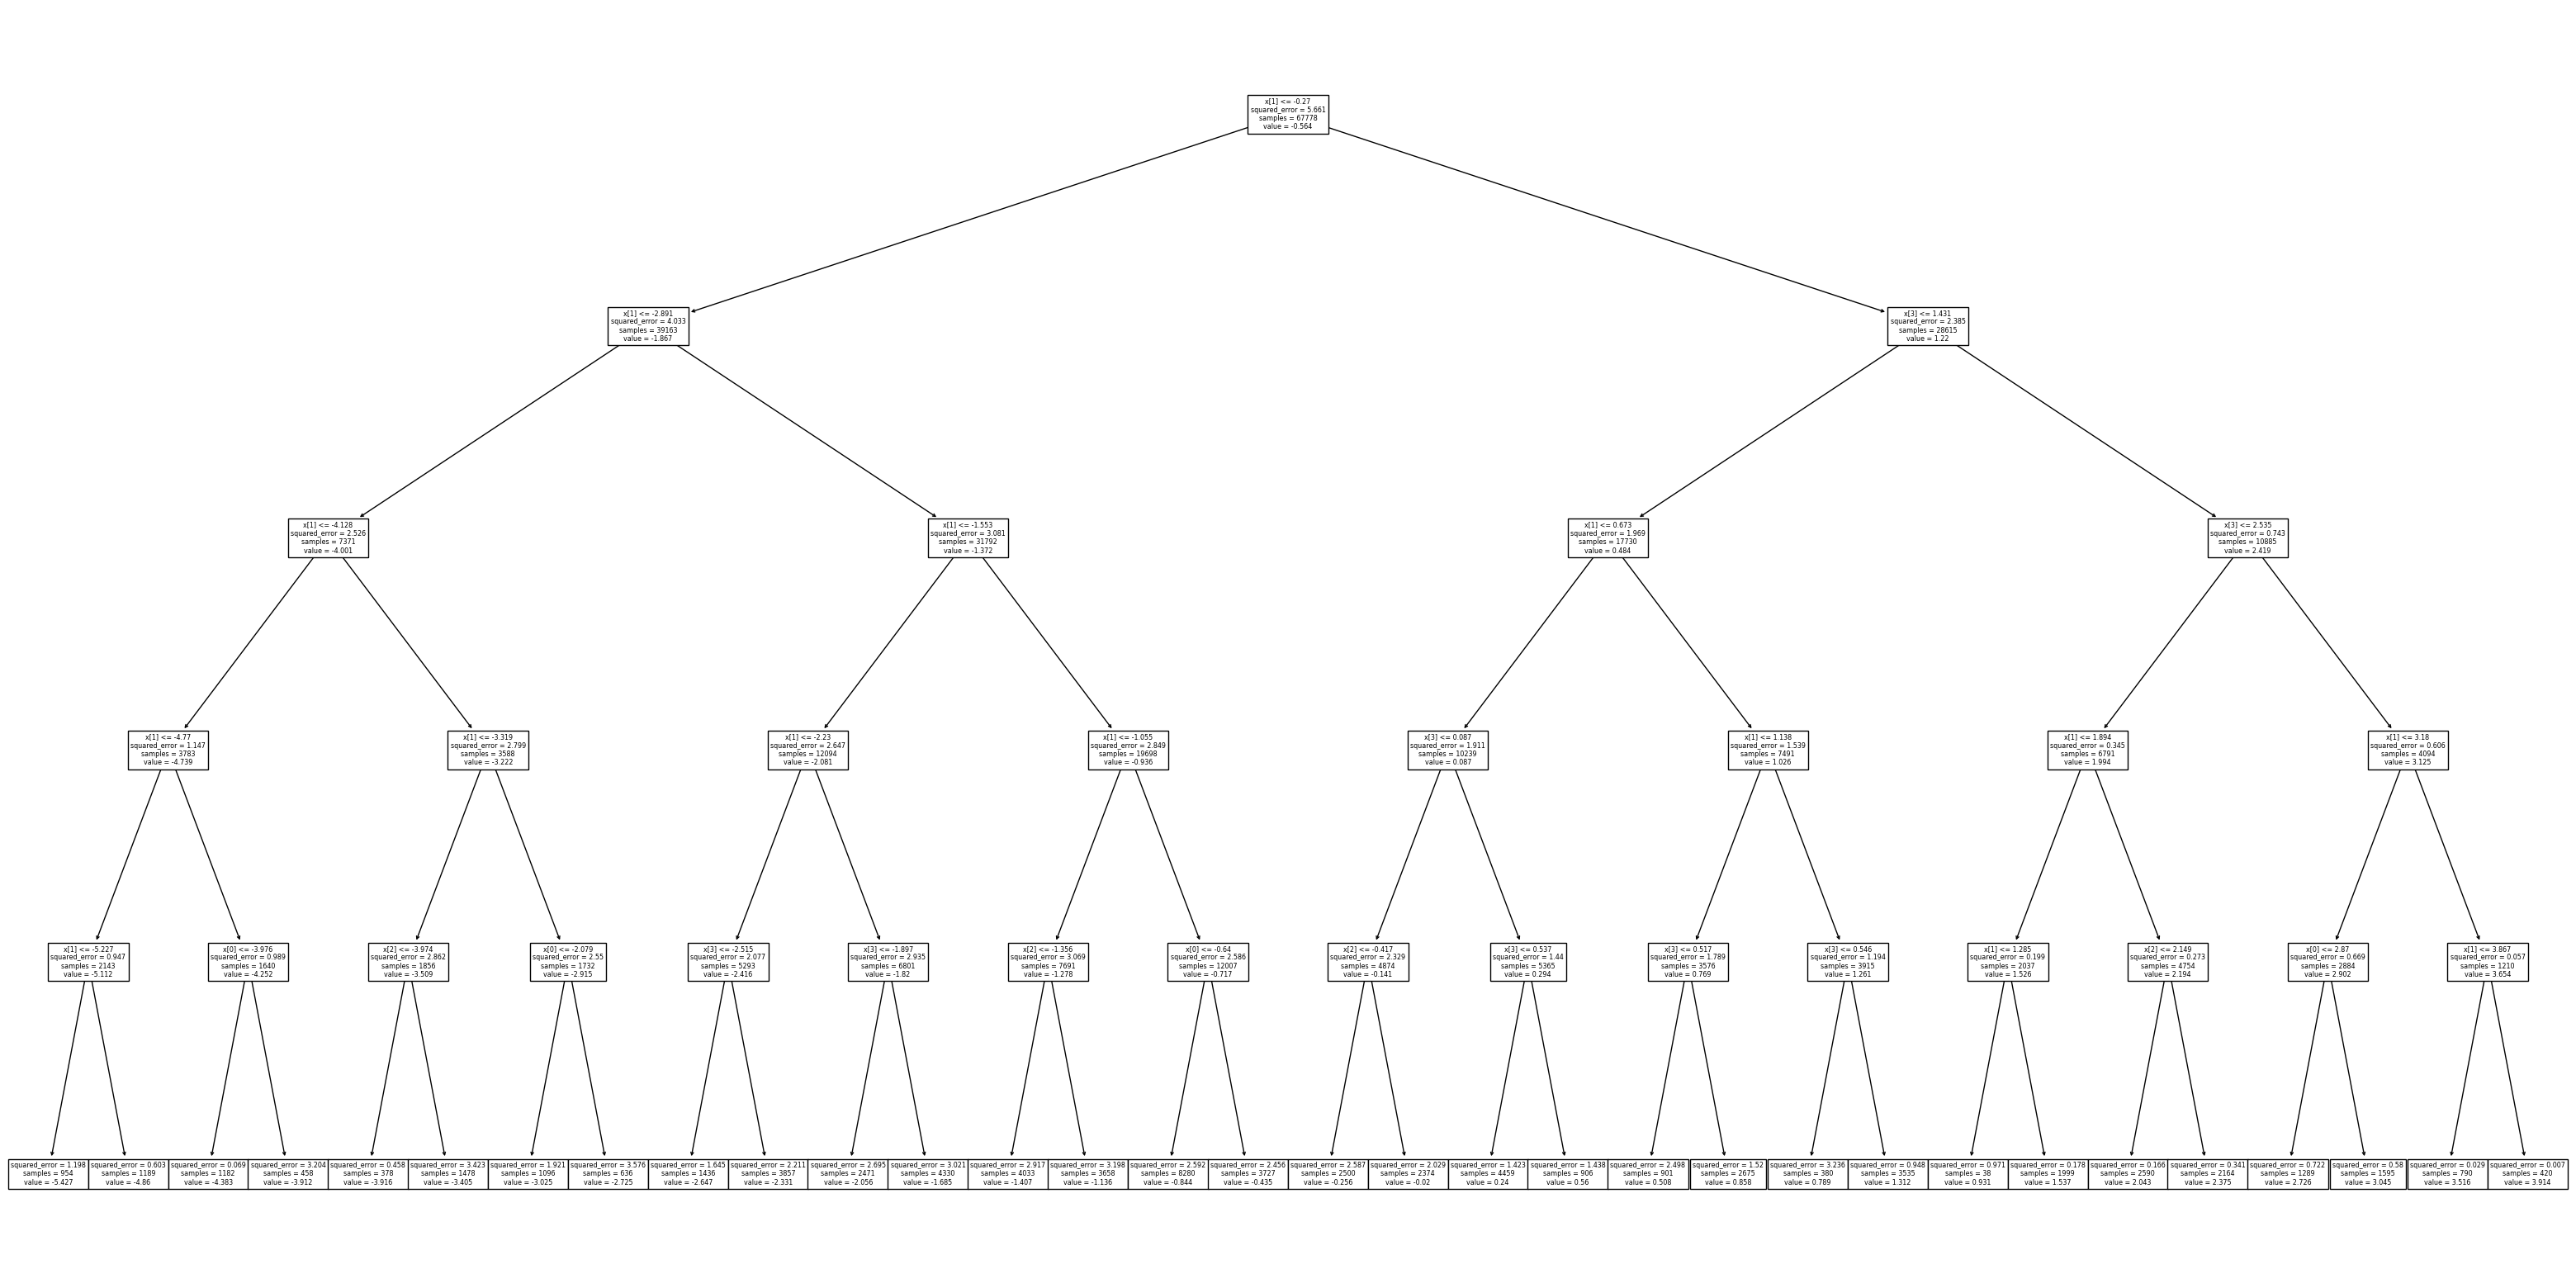

In [87]:
from sklearn.tree import plot_tree
plt.figure(figsize=(40,20))
plot_tree(fitted_stack.final_estimator_, class_names=True)
plt.show()

In [96]:

example = pd.Series(["I ate lunch today"])

example = example.str.lower()
example = example.apply(lambda text: ' '.join([word for word in text.split() if word not in (stop_words)]))

example = example.apply(remove_tags)
example = example.apply(remove_non_printable)
example = example.apply(remove_punctuation)

print(example)


final_example = generate_feature_df(example)

print(fitted_stack.predict(final_example))

0    ate lunch today
dtype: object
[-0.71732906]


# Unused Networks

In [84]:
'''
final_pipe_4 = Pipeline([
    ('scaler', StandardScaler()),
('model', LinearRegression())
])

params_4 = {'model__fit_intercept': [True, False]}

## Perform the grid search
grid_4 = GridSearchCV(final_pipe_4, param_grid=params_4, cv=5, scoring = 'neg_root_mean_squared_error').fit(final_X, train_y)
print(grid_4.best_estimator_)
print(grid_4.best_score_)


test_preds_4 = grid_4.predict(final_test_X)
print(math.sqrt(mean_squared_error(test_preds_4, test_y)))
'''

"\nfinal_pipe_4 = Pipeline([\n    ('scaler', StandardScaler()),\n('model', LinearRegression())\n])\n\nparams_4 = {'model__fit_intercept': [True, False]}\n\n## Perform the grid search\ngrid_4 = GridSearchCV(final_pipe_4, param_grid=params_4, cv=5, scoring = 'neg_root_mean_squared_error').fit(final_X, train_y)\nprint(grid_4.best_estimator_)\nprint(grid_4.best_score_)\n\n\ntest_preds_4 = grid_4.predict(final_test_X)\nprint(math.sqrt(mean_squared_error(test_preds_4, test_y)))\n"

In [ ]:
cv_stacked_preds = grid_forest.predict(final_test_X)
print(math.sqrt(mean_squared_error(cv_stacked_preds, test_y)))


NameError: name 'grid_forest' is not defined

In [ ]:
from sklearn.ensemble import RandomForestRegressor
pipe = Pipeline([
                  ('model', RandomForestRegressor(max_depth=3, min_samples_split=10,
                                   max_features=2, n_estimators=100,
                                   random_state=0, oob_score=True))])

params = {'model__max_depth': [5],
          'model__min_samples_split': [20,60],
          'model__max_features': [2,4,6,8],
          'model__n_estimators': [25,50,100]

         }


## Perform the grid search
grid_forest = GridSearchCV(pipe, param_grid=params, cv=5, scoring = 'neg_root_mean_squared_error').fit(final_X, train_y)
print(grid_forest.best_estimator_)
print(grid_forest.best_score_)


# Network(Nonfunctional)

Contains code adapted from
https://remiller1450.github.io/ml24/torch_lab4.html.

In [ ]:
#Splitting
nn_train, nn_test = train_test_split(df, test_size=.1, train_size=0.1)

nn_train_y = nn_train['hate_speech_score']
nn_train_X = nn_train['text']

nn_test_y = nn_test['hate_speech_score']
nn_test_X = nn_test['text']

In [ ]:


nn_train_X = nn_train_X.str.lower()
nn_train_X = nn_train_X.apply(lambda text: ' '.join([word for word in text.split() if word not in (stop_words)]))

nn_train_X = nn_train_X.apply(remove_tags)
nn_train_X = nn_train_X.apply(remove_mentions)

nn_train_X = nn_train_X.apply(remove_non_printable)
#nn_train_X = nn_train_X.apply(remove_punctuation)

nn_test_X = nn_test_X.str.lower()
nn_test_X = nn_test_X.apply(lambda text: ' '.join([word for word in text.split() if word not in (stop_words)]))
nn_test_X = nn_test_X.apply(remove_tags)
nn_test_X = nn_test_X.apply(remove_mentions)
nn_test_X = nn_test_X.apply(remove_non_printable)

In [ ]:
import string
all_letters = string.ascii_letters + " @.,;'!&*~"
n_letters = len(all_letters)


def textToTensor(line):
    tensor = torch.zeros(600, 1, n_letters)
    for li, letter in enumerate(line):
        #print(li, letter)
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

In [ ]:



train_X_tensor = torch.stack([textToTensor(text) for text in nn_train_X])
train_y_tensor = torch.tensor(nn_train_y.values, dtype=torch.float)
test_X_tensor = torch.stack([textToTensor(text) for text in nn_test_X])
test_y_tensor = torch.tensor(nn_test_y.values, dtype=torch.float)

In [ ]:
train_X_tensor.shape

torch.Size([13555, 492, 1, 62])

In [ ]:
class my_rnn(nn.Module):

    ## Constructor commands
    def __init__(self, input_size, hidden_size, output_size):
        super(my_rnn, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    ## Function to generate predictions
    def forward(self, input, hidden):

        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
h_size = 300
rnn = my_rnn(n_letters, h_size, 1)


In [ ]:
import random
def randomTrainingExample():
    id = random.randint(0, len(train_X_tensor)-1)
    text = train_X_tensor[id]
    score = train_y_tensor[id]
    return text, score



In [ ]:
## Set learning rate
learning_rate = 0.1

## Define cost func
cost_fn = nn.MSELoss()

## Training function for a single input
def train(comment, hate_score):

    ## initialize the hidden state
    hidden = rnn.initHidden()

    ## set the gradient to zero
    rnn.zero_grad()

    for i in range(comment.size()[0]):
        output, hidden = rnn(comment[i], hidden)


    cost = cost_fn(output, hate_score)

    cost.backward()

    # Update parameters
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha = -learning_rate)

    ## Return the output and cost
    return output, cost.item()

In [ ]:
## Initializations
import random

epochs = 250
cost_every_n = 10
current_cost = 0
track_cost = []

n = len(train_y)
idx = random.sample(range(n), n)


### Iteratively update model from randomly chosen example
for iter in range(1, epochs + 1):
    text,score = randomTrainingExample()
    output, cost = train(text, score.float().unsqueeze(0))
    current_cost += cost

    if iter % cost_every_n == 0:
        track_cost.append(current_cost/cost_every_n)
        current_cost = 0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


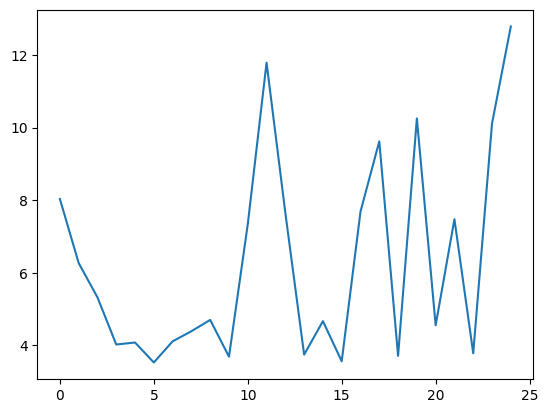

In [ ]:
import matplotlib.pyplot as plt
plt.plot(track_cost)
plt.show()

In [ ]:
def predict(input_line):
    print('\n> %s' % input_line)

    ## Don't update gradient with any of these examples
    with torch.no_grad():

        ## Initialize new hidden state
        hidden = rnn.initHidden()

        ## Convert input str to tensor
        input_t = textToTensor(input_line)

        ## Pass each character into `rnn`
        output, hidden = rnn(input_t[i], hidden)

        return output


predict('I hope you are well trans love')





> I hope you are well trans love


tensor([[0.]])